In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


# 记点笔记

## 常用工具
* numba
* swifter
* sklearn：太老了打比赛一般用里面的模型指标、数据集切分、数据编码，不用里面的模型

In [ ]:
# numba：加速计算如numpy，且支持cuda

# eg.计算矩阵所有元素和
!pip install numba

import numba

@numba.jit(nopython=True)
def cal_sum(m):
    result = 0
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            result += m[i,j]
    return result

In [ ]:
# swifter：加速pandas dataframe和series计算（采取向量化操作）

# eg.对df某列进行操作并存到新的列中
!pip install -U pandas # upgrade pandas
!pip install swifter # first time installation
!pip install swifter[groupby] # first time installation including dependency for groupby.apply functionality

!pip install -U swifter # upgrade to latest version if already installed
!pip install -U swifter[groupby] # upgrade to latest version to include dependency for groupby.apply functionality

import pandas as pd
import swifter

df = pd.DataFrame({'x': [1, 2, 3, 4], 'y': [5, 6, 7, 8]})

# runs on single core
df['x2'] = df['x'].apply(lambda x: x**2)
# runs on multiple cores
df['x2'] = df['x'].swifter.apply(lambda x: x**2)

## 常用模型
* lightbgm
* xgboost
* catboost

它们有两种接口：sklearn风格的接口和原生接口。原生接口一般针对data有单独的一层包装，效率比sklearn接口更高

## 连续特征预处理
1. 补充缺失值
    * 用0补充
    * 用均值补充
  
  但是LGB模型内部对缺失值有自己的一套处理机制，我们可以不进行处理


2. 剔除异常值


3. 归一化/标准化
    * min-max
    * Z-Score
    * Log
  
  针对LGB或者树模型，对归一化的感知可能不是很明显。但是其他模型比如神经网络，归一化很重要

## 离散特征预处理
1. 补充缺失值
    * 用“-1”填充（LGB也可以不处理），比如有人没有写性别


2. 剔除异常值
    * 出现频次太低的值，比如某个省份仅出现一次


3. 数据编码
    * Label-Enc
    * Count-Enc
    * 其它

## 模型验证方法
* hold out验证：将数据按照一定比例随机切分成训练集、验证集、测试集来验证
* 交叉验证：打比赛用最多
  * K-Fold：纯随机分（数据量大可行）
  * Stratified K-Fold：保证每个fold内标签分布稳定
  * ShuffleSplit：比如随即划分10份，但是不适用所有的数据（使用很少）  

# Baseline代码

In [2]:
!pip install swifter  # 选用swifter进行加速

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=a1134e3447dd1f5e941ce47f6009f383bde07e94c0809d9937f701a0b8f50565
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter


In [3]:
from tqdm.notebook import tqdm
import lightgbm as lgb
import swifter
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

## 数据处理

In [4]:
train_df = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')

In [5]:
# 将两个放一起，同时数据处理
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)  # 不保留以前的index

In [6]:
df.info(verbose=True, null_counts=True)
# 可以发现数据无缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 33 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1600000 non-null  int64  
 1   f_00    1600000 non-null  float64
 2   f_01    1600000 non-null  float64
 3   f_02    1600000 non-null  float64
 4   f_03    1600000 non-null  float64
 5   f_04    1600000 non-null  float64
 6   f_05    1600000 non-null  float64
 7   f_06    1600000 non-null  float64
 8   f_07    1600000 non-null  int64  
 9   f_08    1600000 non-null  int64  
 10  f_09    1600000 non-null  int64  
 11  f_10    1600000 non-null  int64  
 12  f_11    1600000 non-null  int64  
 13  f_12    1600000 non-null  int64  
 14  f_13    1600000 non-null  int64  
 15  f_14    1600000 non-null  int64  
 16  f_15    1600000 non-null  int64  
 17  f_16    1600000 non-null  int64  
 18  f_17    1600000 non-null  int64  
 19  f_18    1600000 non-null  int64  
 20  f_19    1600000 non-null

In [7]:
train_df.head()
# 包含numerical型和category型

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [9]:
# 这里发现f_27非常奇怪，是由10个大写字母组成的字符串
# 参考别人的方法可以考虑将每一个字符抽出来，作为一个特征
for i in range(10):
    df[f'ch_{i}'] = df['f_27'].str.get(i).apply(ord) - ord('A')

In [10]:
num_cols  =  ['f_00',
             'f_01',
             'f_02',
             'f_03',
             'f_04',
             'f_05',
             'f_06',
             'f_19',
             'f_20',
             'f_21',
             'f_22',
             'f_23',
             'f_24',
             'f_25',
             'f_26',
             'f_28',]
cate_cols = ['f_07',
             'f_08',
             'f_09',
             'f_10',
             'f_11',
             'f_12',
             'f_13',
             'f_14',
             'f_15',
             'f_16',
             'f_17',
             'f_18',
#              'f_27',
             'f_29',
             'f_30'] + [f'ch_{i}' for i in range(10)]

  0%|          | 0/16 [00:00<?, ?it/s]

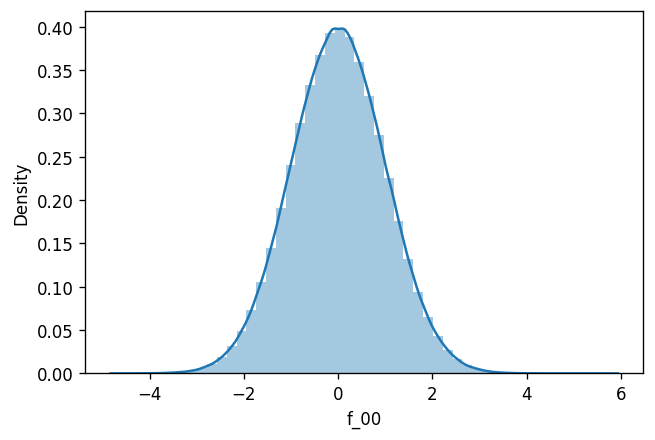

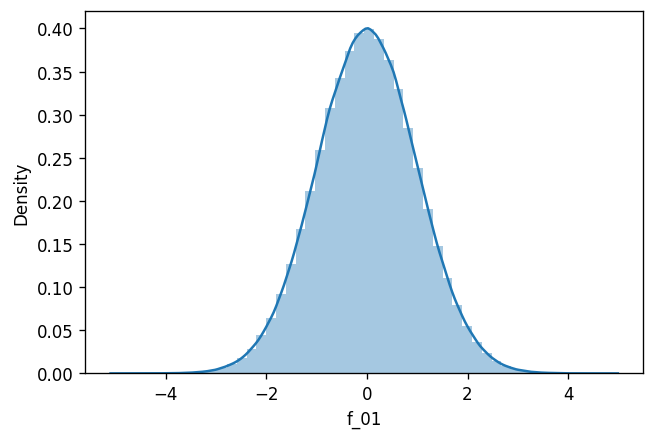

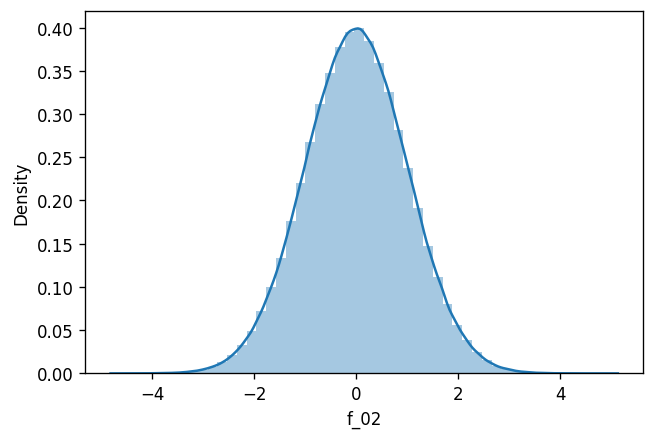

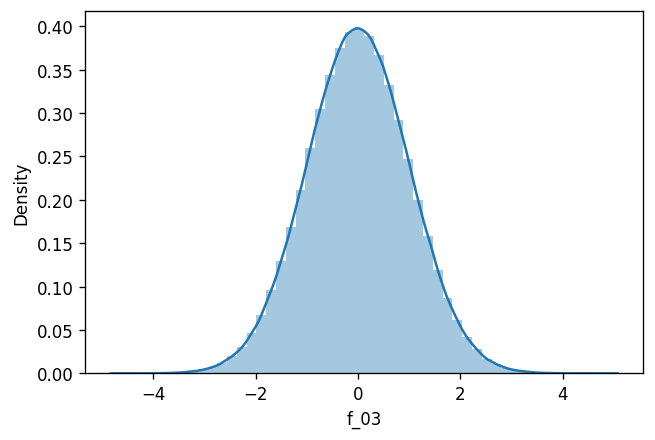

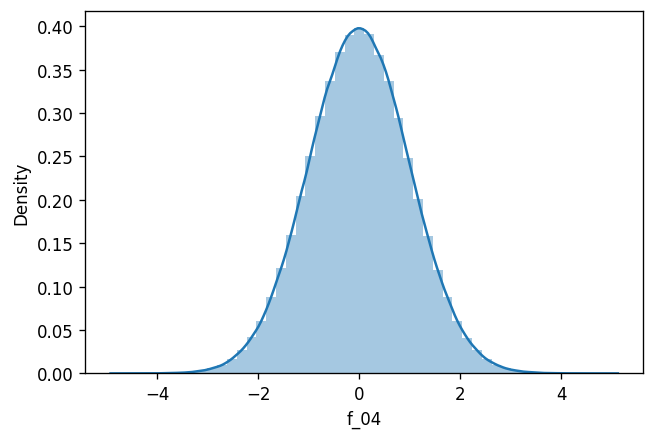

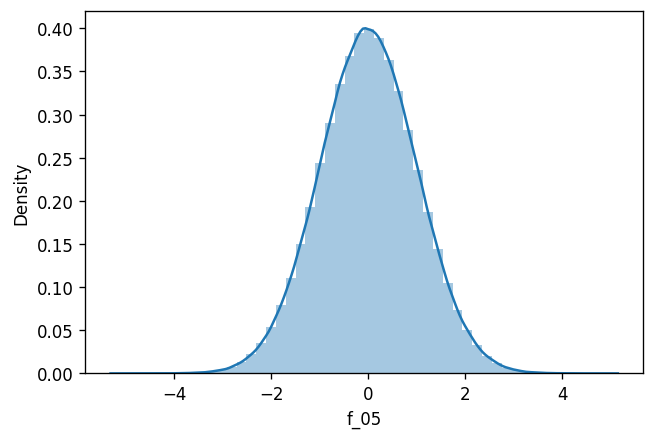

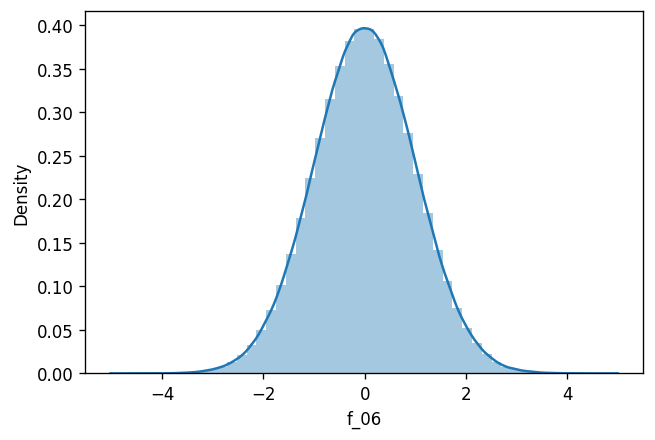

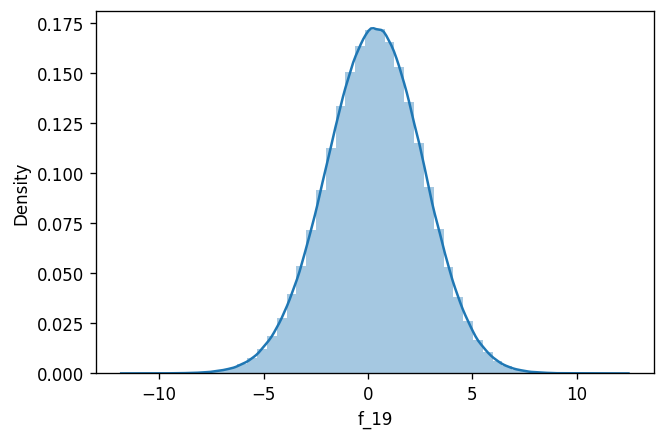

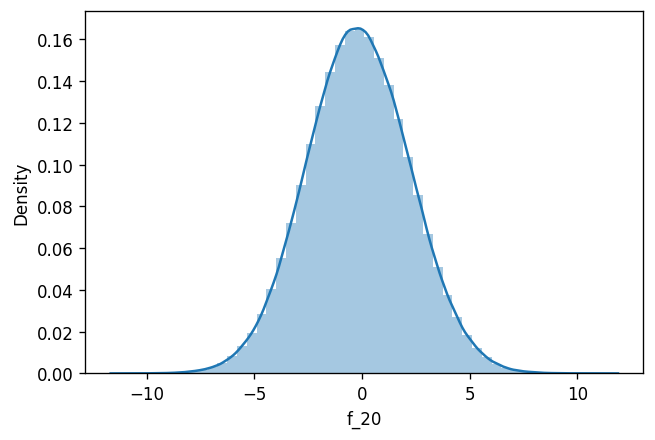

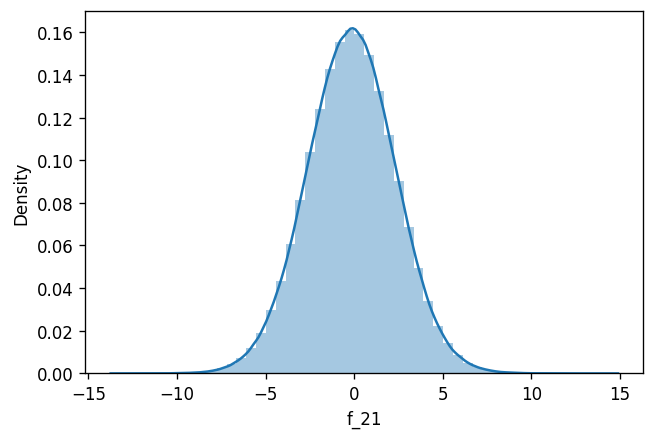

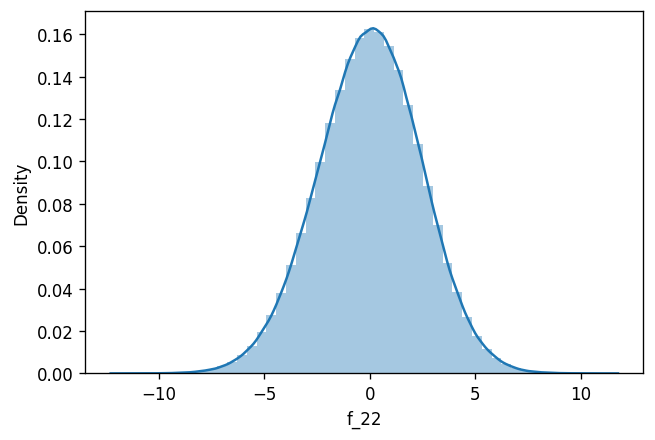

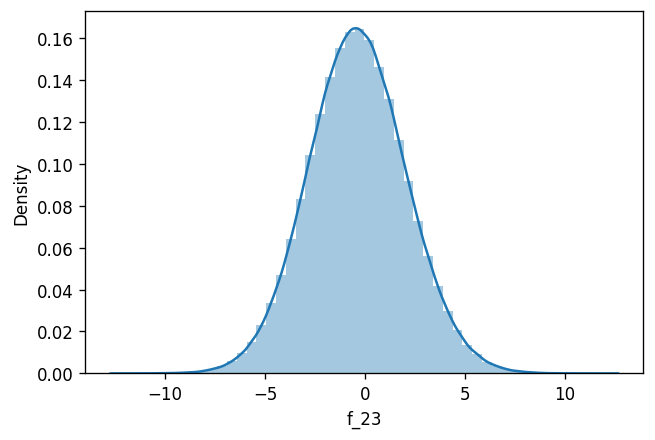

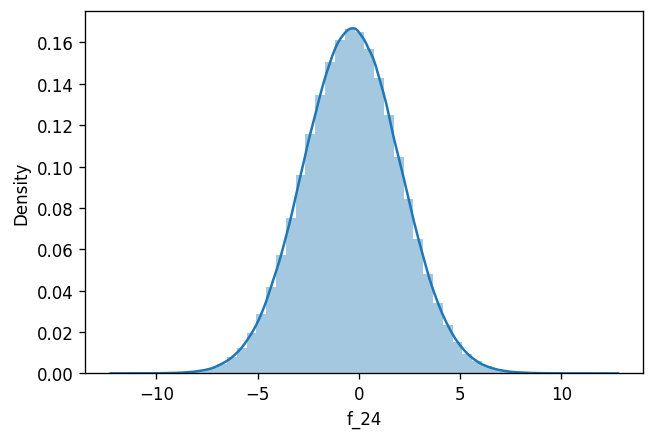

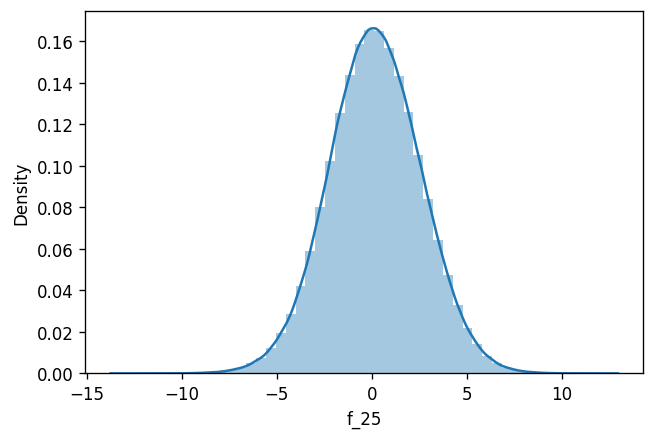

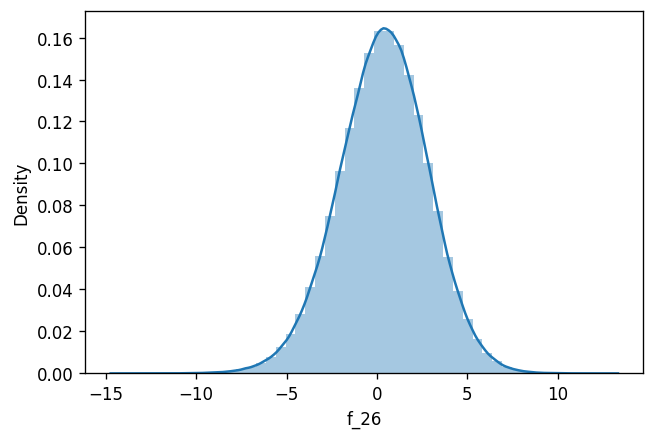

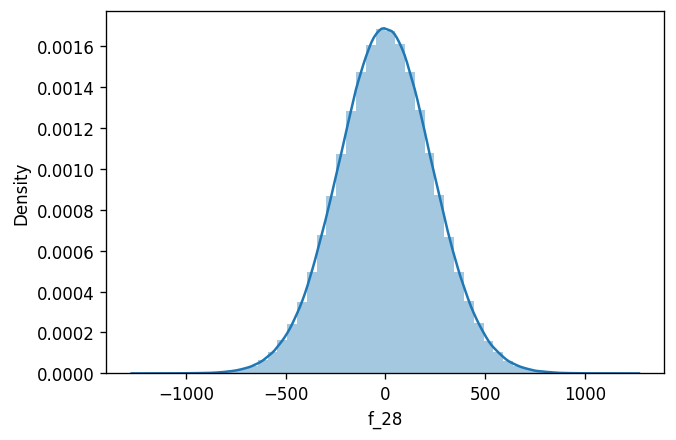

In [12]:
# 观察连续特征值的分布
for col in tqdm(num_cols):
    plt.figure(dpi=120)
    sns.distplot(df[col])

In [14]:
# 对连续特征进行编码
# 这里没有缺失值和异常值，直接归一化就行
# 没有很大/偏离的数据，可以min-max
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

  0%|          | 0/24 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


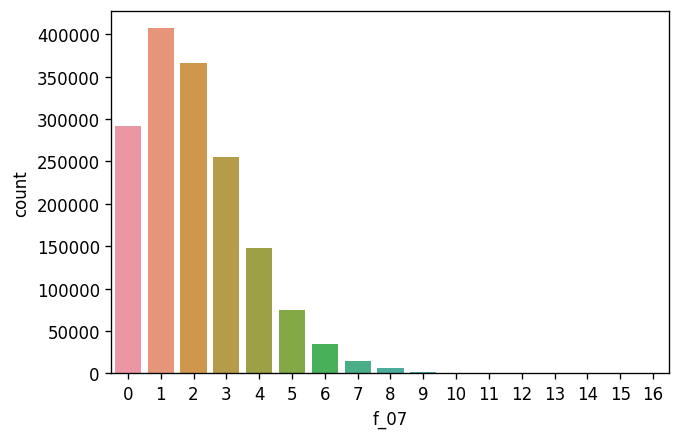

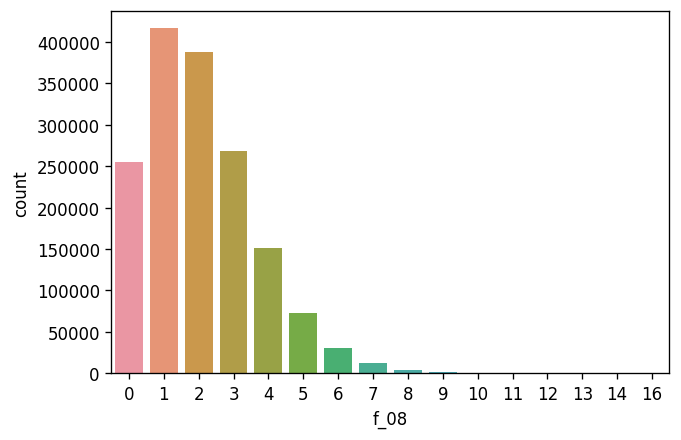

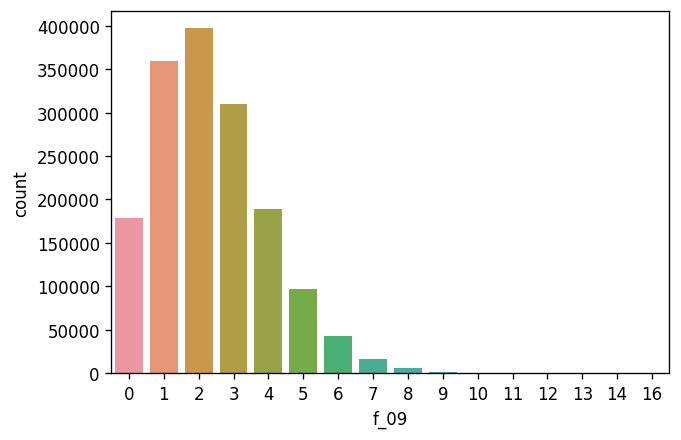

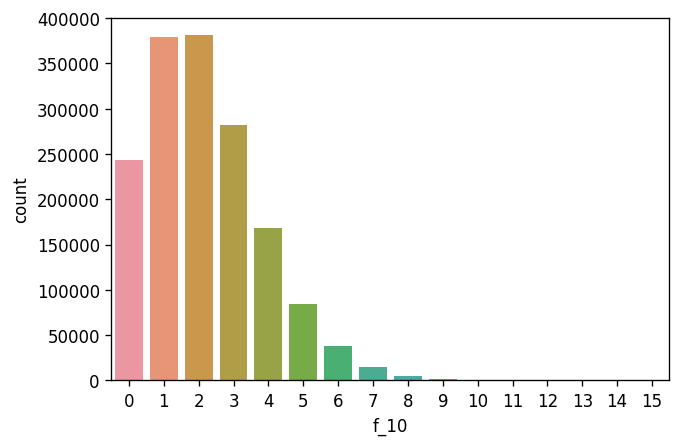

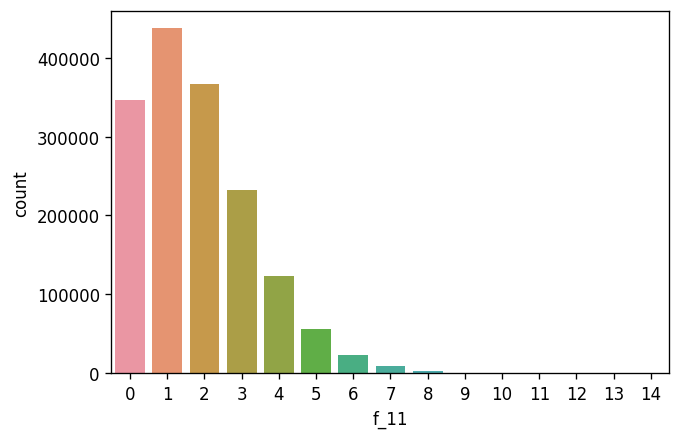

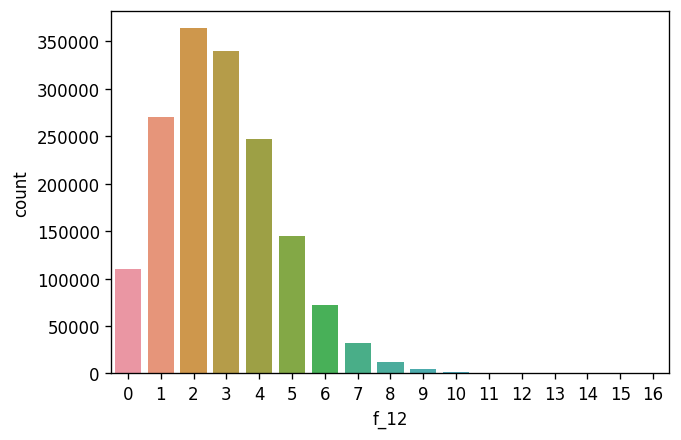

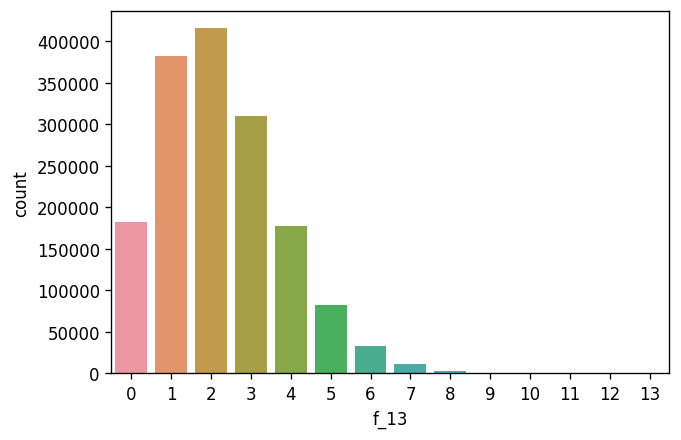

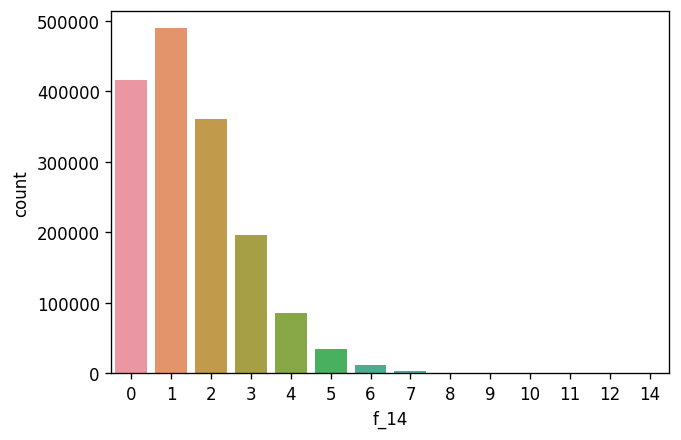

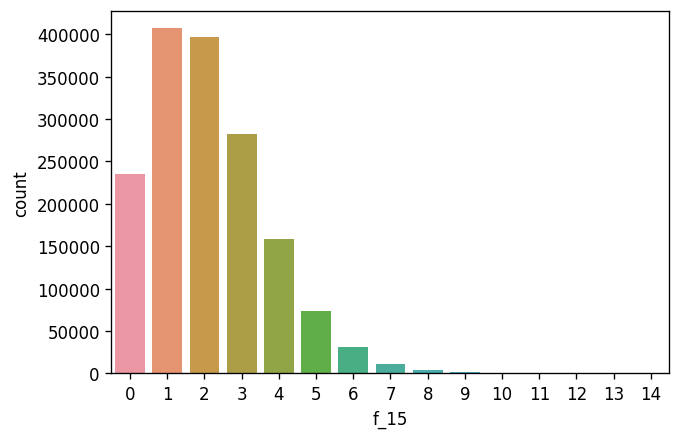

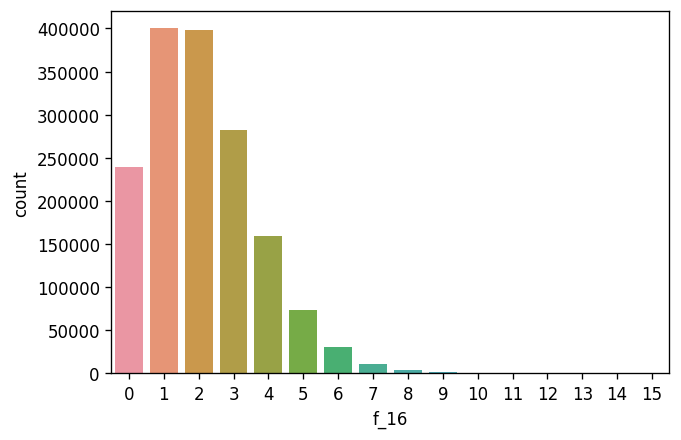

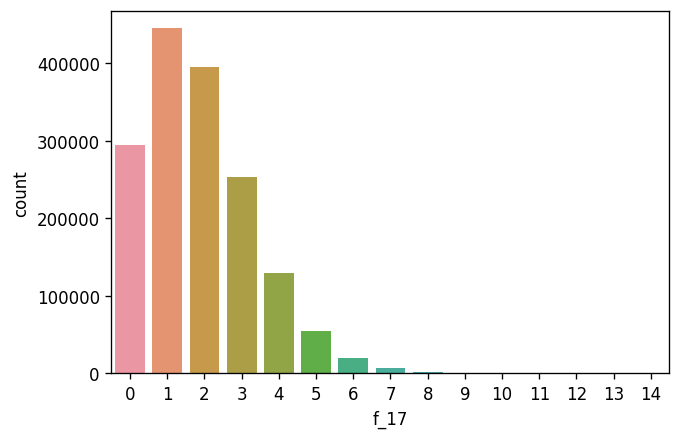

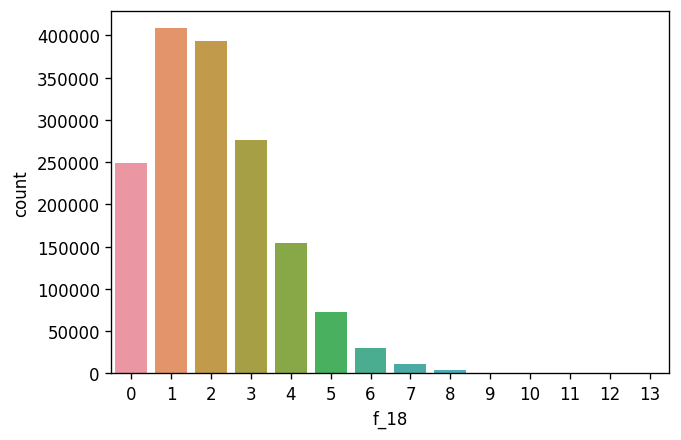

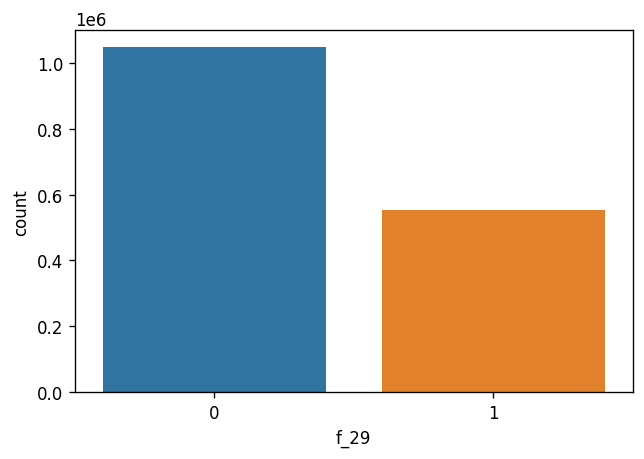

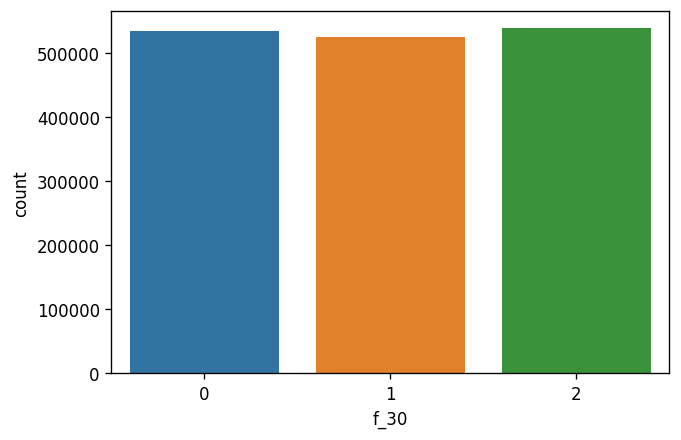

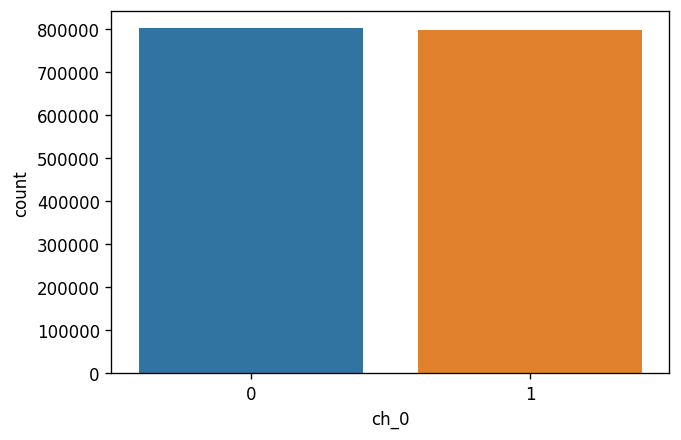

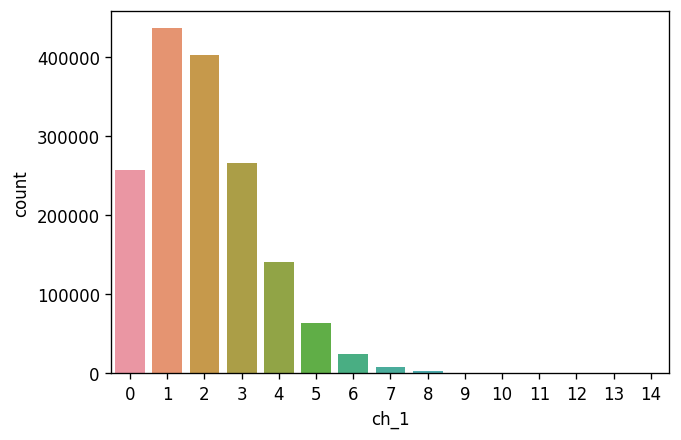

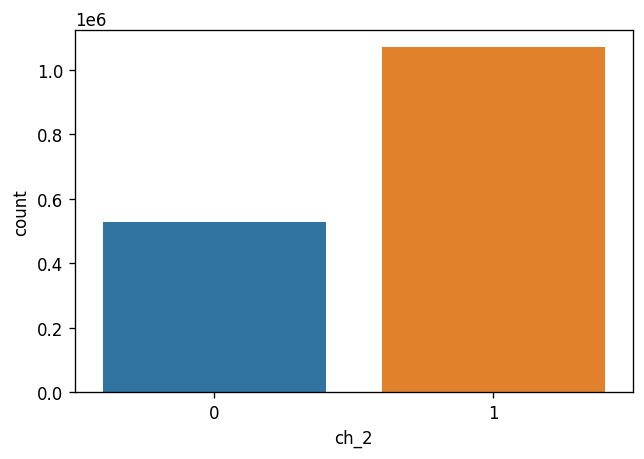

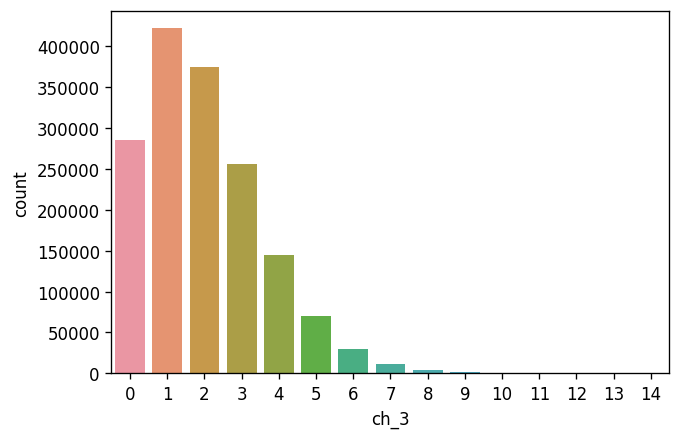

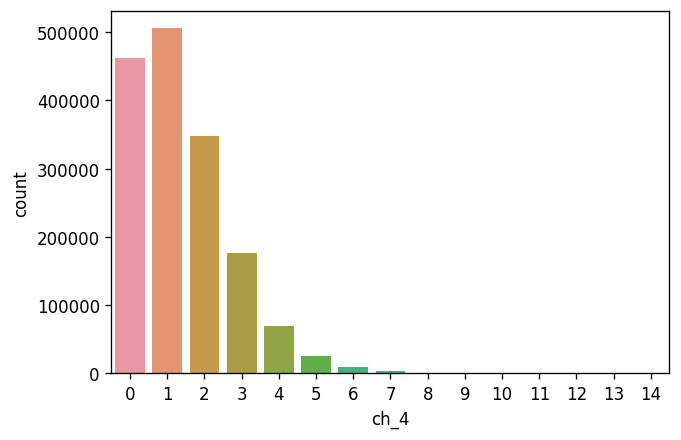

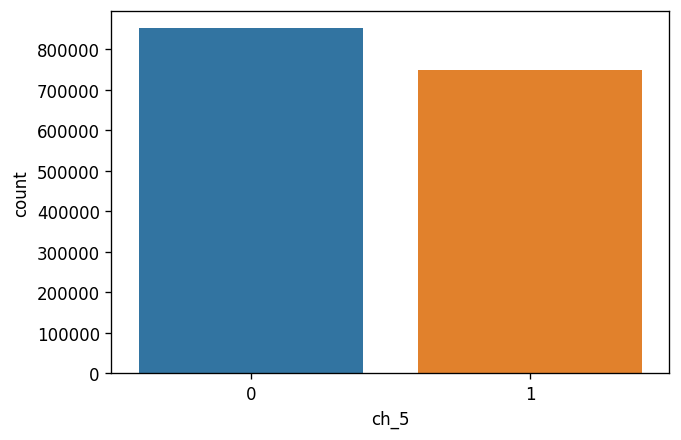

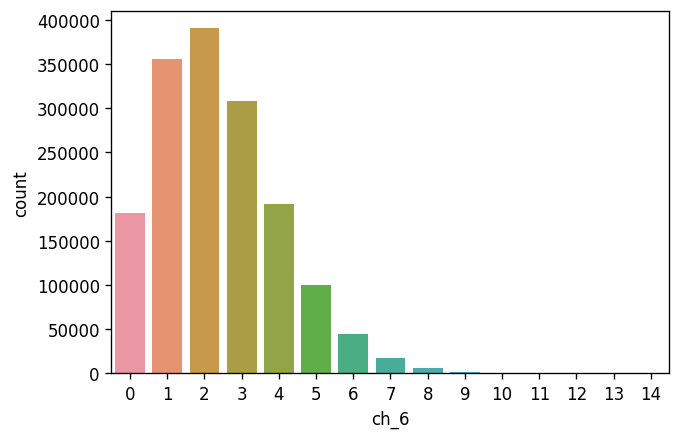

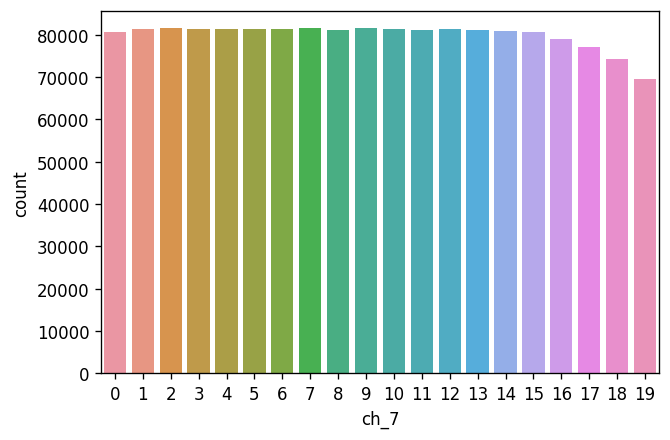

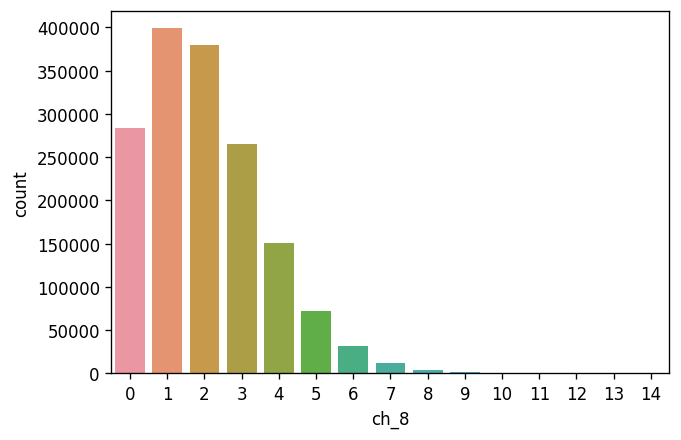

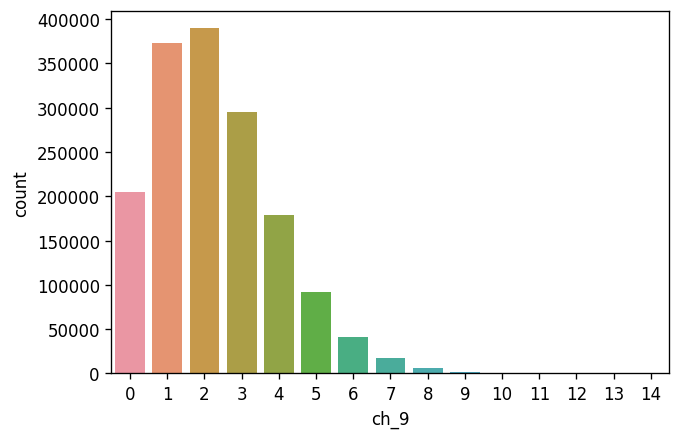

In [16]:
# 观察离散特征 每个值的数量
for col in tqdm(cate_cols):
    plt.figure(dpi=120)
    sns.countplot(df[col])

In [17]:
# 对离散特征进行编码 采用LabelEncode
# 因为我们考虑用树模型lgb
for col in tqdm(cate_cols):
    map_dict = dict(zip(df[col].unique(), range(df[col].nunique())))  # k-v: 离散值从0开始编码
    df[col] = df[col].map(map_dict)  # 编码
    df[f'{col}_count'] = df[col].map(df[col].value_counts())

  0%|          | 0/24 [00:00<?, ?it/s]

In [18]:
# 获得处理后的train、test数据
train_df = df[df['target'].notna()].reset_index(drop=True)
test_df = df[df['target'].isna()].reset_index(drop=True)

In [19]:
# 选择模型训练时需要用到的特征
drop_features = ['id', 'f_27', 'target']
features = [x for x in train_df.columns if x not in drop_features]
print(len(features), features)

64 ['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28', 'f_29', 'f_30', 'ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'f_07_count', 'f_08_count', 'f_09_count', 'f_10_count', 'f_11_count', 'f_12_count', 'f_13_count', 'f_14_count', 'f_15_count', 'f_16_count', 'f_17_count', 'f_18_count', 'f_29_count', 'f_30_count', 'ch_0_count', 'ch_1_count', 'ch_2_count', 'ch_3_count', 'ch_4_count', 'ch_5_count', 'ch_6_count', 'ch_7_count', 'ch_8_count', 'ch_9_count']


## 模型训练

In [21]:
# 模型：lgb
# 验证：k-fold
n_fold = 5
params = {
    'num_leaves': 60,  # 对结果影响大，一般来说越大越好，但要防止过拟合
    'min_data_in_leaf': 30, 
    'objective': 'binary',   # 二分类
    'max_depth': -1, 
    'learning_rate': 0.1, 
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,  #提取的特征比率
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.1,             #l1正则
    # 'lambda_l2': 0.001,     #l2正则
    "verbosity": -1,
    "nthread": -1,                #线程数量，-1表示全部线程，线程越多，运行的速度越快
    'metric': {'binary_logloss', 'auc'},  ##评价函数选择
    "random_state": 66, #随机数种子，可以防止每次运行的结果不一致
    # 'device': 'gpu' ##如果安装的gpu版本的lightgbm,可以加快运算
}

oof_pre = np.zeros(len(train_df))
y_pre = np.zeros(len(test_df))

In [25]:
kf = KFold(n_splits=n_fold)
for fold_, (trn_idx, val_idx) in enumerate(kf.split(train_df)):
    trn_data = lgb.Dataset(train_df[features].iloc[trn_idx], label=train_df['target'].iloc[trn_idx])
    val_data = lgb.Dataset(train_df[features].iloc[val_idx], label=train_df['target'].iloc[val_idx])
    
    clf = lgb.train(params, 
                   trn_data, 
                   100000, 
                   valid_sets=[trn_data, val_data], 
                   verbose_eval=50, 
                   early_stopping_rounds=50)
    
    oof_pre[val_idx] = clf.predict(train_df[features].iloc[val_idx], num_iteration=clf.best_iteration)
    
    y_pre += clf.predict(test_df[features], num_iteration=clf.best_iteration) / n_fold

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.406309	training's auc: 0.924275	valid_1's binary_logloss: 0.408529	valid_1's auc: 0.922465
[100]	training's binary_logloss: 0.338741	training's auc: 0.942562	valid_1's binary_logloss: 0.343081	valid_1's auc: 0.93994
[150]	training's binary_logloss: 0.305056	training's auc: 0.95183	valid_1's binary_logloss: 0.311415	valid_1's auc: 0.948563
[200]	training's binary_logloss: 0.283805	training's auc: 0.95765	valid_1's binary_logloss: 0.291757	valid_1's auc: 0.953942
[250]	training's binary_logloss: 0.270203	training's auc: 0.961414	valid_1's binary_logloss: 0.279959	valid_1's auc: 0.957117
[300]	training's binary_logloss: 0.258893	training's auc: 0.964656	valid_1's binary_logloss: 0.270568	valid_1's auc: 0.959745
[350]	training's binary_logloss: 0.250392	training's auc: 0.967006	valid_1's binary_logloss: 0.264013	valid_1's auc: 0.961456
[400]	training's binary_logloss: 0.243521	training's auc: 0.9

In [29]:
# 将结果写入文件
import pandas

res_df = pandas.DataFrame()
res_df['id'] = test_df['id']
res_df['target'] = y_pre
res_df.to_csv('/kaggle/working/baseline.csv',index=False)